In [18]:
import math
import io
import torch
from torchvision import transforms
import numpy as np
import pickle
import re
import scipy.stats as st
import PIL
from collections import Counter
from PIL import Image
from PIL import ImageChops
import imageio
from pytorch_msssim import ssim, ms_ssim
import matplotlib.pyplot as plt
from statistics import mean
import compressai
import skimage
import torch.nn.functional as F
from compression import rates
from quality import psnr
from compression import rates
from oligochecker import size
from oligoanalyzer import gc_stats
from oligoanalyzer import homopolymer_stats
from IQA_pytorch import NLPD, VIF, FSIM

In [19]:
from compressai.zoo import bmshj2018_factorized
from compressai.dna_entropy_coding.coder import Coder
from ipywidgets import interact, widgets

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
JPEG_SIZES = [
    '1192x832', 
    '853x945', 
    '945x840', 
    '2000x2496', 
    '560x888',
    '2048x1536', 
    '1600x1200', 
    '1430x1834', 
    '2048x1536', 
    '2592x1946'  
]

In [22]:
DATA_SET_LIST = [
    'kodak', 
    'jpeg_dna'
]

In [149]:
METRICS_LIST = [
    #'PSNR', 
    #'PSNR-YUV', 
    #'PSNR-Y-CB-CR', 
    'MS-SSIM', 
    'IW-SSIM', 
    'NLPD', 
    'VIF', 
    'Homopolymer density'
]

In [24]:
MODELS_LIST = [
    'benchmarkcodec', 
    'anchor1', 
    'anchor3', 
    'learningbased', 
    'BCtranscoder'
]

### Image extraction

In [25]:
def get_original_tensor(data_set, img_id): 
    path = get_original_image_path(data_set, img_id)
    img = Image.open(path).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [26]:
def get_original_image_path(data_set, img_number): 
    img_path = 'assets/' + data_set
    if data_set == 'kodak':
        img_name = '/kodim{:02d}.png'.format(img_number)
        
    if data_set == 'jpeg_dna': 
        img_name = f"/{str(img_number).zfill(5)}_" + JPEG_SIZES[img_number-1]+'.png'
    return img_path + img_name

In [27]:
def get_decoded_image_path(data_set, model_name, img_number, quality): 
    path = 'assets/' + data_set +'/' + model_name
    img_name = ''
    if data_set == 'kodak': 
        img_name = '/{}kodim{:02d}.png'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        img_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '_decoded' + '.png'
    else : 
        return ''
    return path + img_name

In [28]:
def get_decoded_tensor(data_set, model_name, img_number, quality):
    path = get_decoded_image_path(data_set, model_name, img_number, quality)
    img = Image.open(path).convert('RGB')   
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [29]:
def get_dna_path(data_set, model_name, img_number, quality): 
    path = 'assets/' + data_set +'/' + model_name
    dna_name = ''
    if data_set == 'kodak': 
        dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        dna_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '.fasta'
    else : 
        return ''
    return path + dna_name

In [30]:
def get_dna(data_set, model_name, img_number, quality):
    path = get_dna_path(data_set, model_name, img_number, quality)
    fasta_file = open(path)
    dna = fasta_file.read()
    fasta_file.close()
    return dna


In [31]:
#print(get_dna('jpeg_dna', 'anchor1', 1, 1))#

# Biochemical constraints

### DNA CG contents

In [32]:
def CG_content(dna) : 
    return 100*(dna.count("C")+dna.count("G"))/len(dna)

In [33]:
def plot_cg_contents(model_name, data_set = 'jpeg_dna'): 
    """
    Plots of the percentage of CG nucleotides in dna strands in regards of the quality of the 
    encoding, computed for the 24 images of the kodak data set.  
    
    Parameters
    ----------
    model_name: string 
        name of the model to be used for dna encoding
        'anchor1', 'anchor3', 'benchmark codec' or 'learning based'
        
    Returns
    -------
    A plot saved in the folder plots/
    """
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10
    else : 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    
    
    for i in range(1, number_of_images+1): 
        cg = []
        bit_rate = []
        print('image' + str(i))
        for q in range(1,8):
            print ('quality' + str(q))
            dna = get_dna(data_set, model_name, i, q)
            img, x = get_decoded_tensor(data_set, model_name, i, q)
            cg.append(CG_content(dna))
            bit_rate.append(compute_bit_rate(img, dna))
            
        plt.plot(bit_rate, cg)
        
    plt.xlabel('Rate (nt/pxl)')
    plt.ylabel('CG content (%)')
    plt.title('CG contents of ' + model_name +' dna for the ' + data_set + ' data set')
    plt.ylim(0, 100) 
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('plots/cg_' + data_set + '_'+ model_name + '.jpeg', bbox_inches='tight')
    plt.show()
    
def plot_all_cg_contents(data_set): 
    for model_name in MODELS_LIST: 
        plot_cg_contents(model_name)
        

### Homopolymers

In [41]:
def count_homopolymers(homopolymer_list, bases_counter, dna_substrand, i):
    """
    Recursively counts the homopolymers in a dna strand
    
    Parameters:
    ----------
        homopolymer_list : list<int>
            list of the length of the homopolymers in the strand
        bases_counter : int
            counter for the number of bases in the homopolymer
        dna_substrand : string
            studied dna strand
        i : int 
            index of the bases in the dna
                                    
    Returns:
    ----------
        The list of the lengths of the homopolymers in the given DNA substrand 
    """
   # Check if we have reached the end of the dna_substrand or if there are less than two bases in the current substring
    if i == 1 or i == 0 or i >= len(dna_substrand):
        # If true, return the homopolymer_list
        return homopolymer_list 
    # Check if the current base is identical to the previous one
    elif dna_substrand[i] == dna_substrand[i-1] : 
        # If true, increment the bases_counter and continue recursively checking the previous base
        return count_homopolymers(homopolymer_list, bases_counter+1, dna_substrand, i-1)
    # Check if we have found a homopolymer
    elif bases_counter >= 7 : 
        # If true, append the length of the homopolymer to the homopolymer_list and reset the bases_counter to 0. 
        # Continue recursively checking the previous base
        homopolymer_list.append(bases_counter+1)
        return count_homopolymers(homopolymer_list, 0, dna_substrand, i-1)
    else : 
        # If none of the above conditions are met, reset the bases_counter to 0 and continue recursively checking the previous base
        return count_homopolymers(homopolymer_list, 0, dna_substrand, i-1)


In [42]:

def check_homopolymers(dna, max_recursion_depth=2970):
    """
    Takes a DNA sequence and calculates the homopolymers present in it.
    
    Parameters:
    ----------
        dna : string
            The DNA sequence to check for homopolymers
        max_recursion_depth : int
            The maximum recursion depth to be used for checking homopolymers.
            Default is set to 2970.
                                   
    Returns:
    ----------
        A tuple containing:
        - The number of homopolymers found
        - A list of homopolymers found
        - The average length of homopolymers found
        - The density of homopolymers found
        
    """
    count = 0 # counter for homopolymers
    homopolymer_list = [] # list to store homopolymers
    avg_len = 0 # variable to store average length of homopolymers
    homopolymer_density = 0 # variable to store density of homopolymers
    
    # Check if the length of the DNA exceeds the recursion depth
    if len(dna) > max_recursion_depth: 
        # Iterate over the sub-strands of an acceptable length
        for i in range(0, len(dna)-1, max_recursion_depth):
            # Get the end index of the sub-strand
            end_index = min(i+max_recursion_depth, len(dna)-1)
            dna_substrand = dna[i:end_index]
            # Count homopolymers in the sub-strand
            homo_in_substrand = count_homopolymers([], 0, dna_substrand, len(dna_substrand)-1)
            if  len(homo_in_substrand)!=0:
                homopolymer_list.extend(homo_in_substrand)
    else: 
        # Count homopolymers in the DNA sequence
        homopolymer_list = count_homopolymers([], 0, dna, len(dna)-1)
        
    if len(homopolymer_list) != 0: 
        # Calculate average length and density of homopolymers
        avg_len = mean(homopolymer_list)
        homopolymer_density = ((avg_len * len(homopolymer_list))/len(dna))*100
    
    # Print the results
    #print("List of homopolymers: ", homopolymer_list)
    #print("Average length of the homopolymers : ", avg_len)
    #print("Density of the homopolymers : ", homopolymer_density, " %")
    
    # Return the results as a tuple
    return len(homopolymer_list), homopolymer_list, avg_len, homopolymer_density


In [43]:
def compute_homopolymer_data(dna, data_name = 'density'): 
    (nbr_homopolymer, homopolymer_list, avg_len, homopolymer_density) = check_homopolymers(dna)
    if data_name == 'density': 
        return homopolymer_density
    elif data_name == 'counter': 
        return nbr_homopolymer
    elif data_name == 'average length': 
        return avg_len
    else : 
        print('Invalid dna data name')
        return

In [121]:
import numpy as np
import matplotlib.pyplot as plt

def plot_homopolymers(data_set, model_name, img_number):
    width = 0.5
    fig, ax = plt.subplots()

    # Get homopolymer lengths for each quality level and store in a list
    homopolymer_length_lists = []
    for quality in range(1, 9):
        dna = get_dna(data_set, model_name, img_number, quality)
        _, homopolymer_lengths, _, _ = check_homopolymers(dna)
        homopolymer_length_lists.append(homopolymer_lengths)

    # Determine max homopolymer length across all lists
    max_lengths = [max(l) for l in homopolymer_length_lists if len(l) > 0]
    max_length = max(max_lengths) if len(max_lengths) > 0 else 99

    # Compute counts for each homopolymer length across all lists
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    bottom = np.zeros(max_length)

    for i, length_list in enumerate(homopolymer_length_lists):
        counts = [0] * max_length
        for length in length_list:
            if length <= max_length:
                counts[length-1] += 1
        p = ax.bar(range(1, max_length+1), counts, width, label='Quality '+str(i+1), bottom=bottom, color=colors[i])
        bottom += counts

    ax.set_title('Distribution of Homopolymer lengths for the image '+ str(img_number) + ' of the ' + data_set + ' data set, using the ' +  model_name + ' model')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.set_xlabel('Homopolymer Length')
    ax.set_ylabel('Number of Homopolymers')
    plt.savefig('plots/homopolymers'+ data_set + '_'+model_name +'_im' + str(img_number) +'.jpeg')

    plt.show()


In [122]:
def plot_all_homopolymers(): 
    for data_set in DATA_SET_LIST:
        if data_set == 'jpeg_dna': 
            number_of_images = 10
        else : number_of_images = 24
        for model_name in MODELS_LIST: 
            for img_number in range(1, number_of_images+1): 
                plot_homopolymers(data_set, model_name, img_number)

In [123]:
#plot_all_homopolymers()

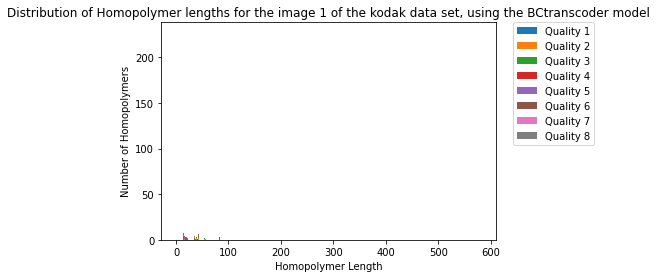

(150,
 [11,
  9,
  13,
  11,
  9,
  49,
  95,
  95,
  67,
  25,
  13,
  51,
  25,
  95,
  87,
  95,
  11,
  9,
  9,
  9,
  9,
  9,
  9,
  15,
  9,
  9,
  9,
  15,
  9,
  9,
  11,
  9,
  9,
  9,
  9,
  11,
  15,
  13,
  9,
  17,
  59,
  34,
  15,
  9,
  9,
  15,
  9,
  9,
  15,
  9,
  9,
  15,
  9,
  9,
  13,
  9,
  9,
  13,
  9,
  9,
  35,
  61,
  35,
  21,
  91,
  97,
  95,
  95,
  57,
  29,
  57,
  9,
  27,
  51,
  9,
  27,
  57,
  9,
  27,
  40,
  13,
  9,
  13,
  9,
  9,
  11,
  11,
  9,
  13,
  9,
  9,
  10,
  11,
  9,
  13,
  9,
  9,
  10,
  11,
  9,
  13,
  9,
  11,
  9,
  11,
  9,
  13,
  9,
  11,
  9,
  13,
  9,
  11,
  181,
  83,
  83,
  9,
  83,
  9,
  31,
  9,
  9,
  9,
  13,
  9,
  9,
  9,
  13,
  9,
  13,
  8,
  9,
  13,
  8,
  9,
  13,
  9,
  9,
  13,
  9,
  9,
  13,
  11,
  13,
  581,
  55,
  9,
  15,
  9,
  9],
 26.44,
 3.4167858435136207)

In [126]:
plot_homopolymers('kodak', 'BCtranscoder', 1)
dna = get_dna('kodak', 'BCtranscoder', 1, 1)
check_homopolymers(dna)


# Objective quality evaluation

In [60]:
def remove_padding(original_tensor, reconstructed_tensor): 
    height = original_tensor.shape[2]
    width = original_tensor.shape[3]
    reconstructed_tensor = reconstructed_tensor[:, :, :height, :width]
    return reconstructed_tensor

### Metrics

#### PSNR


- PSNR = Peak Signal-to-Noise Ratio
- Measures the difference between an original image and a compressed or reconstructed version of it. 
- The higher the PSNR value, the better the quality of the compressed or reconstructed image.

\begin{equation}
PSNR = - 10 \cdot \log_{10} (MSE)
\end{equation}




In [61]:
def compute_psnr(original_tensor, reconstructed_tensor):
    #reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    mse = torch.mean((original_tensor - reconstructed_tensor)**2).item()
    return -10 * math.log10(mse)


In [62]:
def compute_psnr_yuv(original_tensor, reconstructed_tensor):
    #reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    reconstructed_img =  transforms.ToPILImage()(reconstructed_tensor.squeeze().cpu())
    original_img = transforms.ToPILImage()(original_tensor.squeeze().cpu())
    original_img = np.array(original_img)
    reconstructed_img = np.array(reconstructed_img)
    return psnr.psnr_yuv(original_img, reconstructed_img)

In [63]:
def compute_psnr_y_cb_cr(original_tensor, reconstructed_tensor): 
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    reconstructed_img =  transforms.ToPILImage()(reconstructed_tensor.squeeze().cpu())
    original_img = transforms.ToPILImage()(original_tensor.squeeze().cpu())
    original_img = np.array(original_img)
    reconstructed_img = np.array(reconstructed_img)
    return psnr.psnr_y_cb_cr(original_img, reconstructed_img)

#### MS-SSIM
- MS-SSIM = Multi-Scale Structural Similarity Index
- Measures the similarity between two images
- Takes into account multiple scales of image structures
- The higher the MS-SSIM, the higher the similqrity between 2 images

In [64]:
def compute_msssim(original_tensor, reconstructed_tensor):
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    return ms_ssim(original_tensor, reconstructed_tensor, data_range=1.).item()

#### IW-SSIM
- IW-SSIM = Information-Weighted Structural Similarity Index
- Takes into account the importance of different regions in the image, and assigns them different weights based on their visual significance
- The higher the MS-SSIM, the higher the similqrity between 2 images

\begin{equation}
\text{IW-SSIM} = \frac{(2 \mu_a \mu_b + c_1)(2\sigma_{ab} + c_2)}{(\mu_a^2 + \mu_b^2 + c_1)(\sigma_a^2 + \sigma_b^2 + c_2)} \cdot \text{SSIM}
\end{equation}


In [65]:
def compute_iwssim(original_tensor, reconstructed_tensor, k=0.01):
    reconstructed_tensor = remove_padding(original_tensor, reconstructed_tensor)
    # Compute the constants c1 and c2 used in the IW-SSIM formula
    c1 = (k * 1) ** 2
    c2 = (k * 1) ** 2
    # Compute the mean, variance, and covariance of the two input images
    mean_original_tensor = original_tensor.mean(dim=(1, 2, 3), keepdim=True)
    mean_reconstructed_tensor = reconstructed_tensor.mean(dim=(1, 2, 3), keepdim=True)
    var_original_tensor = ((original_tensor - mean_original_tensor) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    var_reconstructed_tensor = ((reconstructed_tensor - mean_reconstructed_tensor) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    cov = ((original_tensor - mean_original_tensor) * (reconstructed_tensor - mean_reconstructed_tensor)).mean(dim=(1, 2, 3), keepdim=True)
    
    # Compute the SSIM value between the two input images using pytorch_msssim's ssim function
    ssim_val = ssim(original_tensor, reconstructed_tensor, data_range=1.0, win_size=11, size_average=True)
    
    # Compute the IW-SSIM value using the mean, variance, covariance, and SSIM values
    iwssim_val = ((2 * mean_original_tensor * mean_reconstructed_tensor + c1) * (2 * cov + c2)) / ((mean_original_tensor ** 2 + mean_reconstructed_tensor ** 2 + c1) * (var_original_tensor + var_reconstructed_tensor + c2)) * ssim_val
    
    # Return the average IW-SSIM value across the batch
    return iwssim_val.mean().item()


#### NLPD


In [66]:
def compute_nlpd(original_tensor, reconstructed_tensor):
    D = NLPD()
    # set requires_grad attribute to True
    reconstructed_tensor.requires_grad = True  
    score = D(reconstructed_tensor, original_tensor, as_loss=False) 
    score_num = score.item()
    # set 'as_loss=True' to get a value as loss for optimizations.
    loss = D(reconstructed_tensor, original_tensor)
    loss.backward()
    return score_num

#### VIF


In [67]:
def compute_vif(original_tensor, reconstructed_tensor):
    D = VIF()
    # set requires_grad attribute to True
    reconstructed_tensor.requires_grad = True  
    score = D(reconstructed_tensor, original_tensor, as_loss=False)
    score_num = score.item()
    # set 'as_loss=True' to get a value as loss for optimizations.
    loss = D(reconstructed_tensor, original_tensor)
    loss.backward()
    return score_num

#### FSIM

In [68]:
def compute_fsim(original_tensor, reconstructed_tensor): 
    D = FSIM()
    # set requires_grad attribute to True
    reconstructed_tensor.requires_grad = True  
    score = D(reconstructed_tensor, original_tensor, as_loss=False)
    score_num = score.item()
    # set 'as_loss=True' to get a value as loss for optimizations.
    loss = D(reconstructed_tensor, original_tensor)
    loss.backward()
    return score_num

In [69]:
def compute_bit_rate(img, dna): 
    h, w = img.size
    return len(dna)/(h*w)

### Plots

In [127]:
def compute_metric(metric_name, original_tensor, reconstructed_tensor): 
    
    """
    Computes the quality metric given by 'metric_name' for an encoded image, 
    in comparison to an original image. 

    Parameters
    ----------
    metric_name: string 
        name of the metric to be computed.
        'PSNR', 'PSNR-YUV', 'PSNR-Y-CB-CR', 'MS-SSIM', 'IW-SSIM'
        
    original_tensor: tensor
        original image run through the different encoder
    reconstructed_tensor: tensor
        reconstructed image tensor
        

    Returns
    -------
    The computed value of the given quality metric for the specified image
    """
    
    if metric_name == 'PSNR' : 
        return compute_psnr(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'PSNR-YUV':
        return compute_psnr_yuv(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'PSNR-Y-CB-CR':
        compute_psnr_y_cb_cr(original_tensor, reconstructed_tensor)
        
    elif metric_name == 'MS-SSIM': 
        return compute_msssim(original_tensor, reconstructed_tensor)
    
    elif metric_name =='IW-SSIM': 
        return compute_iwssim(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'NLPD': 
        return compute_nlpd(original_tensor, reconstructed_tensor)
    
    elif metric_name == 'VIF': 
        return compute_vif(original_tensor, reconstructed_tensor)
    else:
        print("Invalid argument : " + metric_name + ".")
        return

In [128]:
def plot_metric(metric_name, img_number, data_set = 'jpeg_dna'): 
    """
    Plots a quality metric given by metric_name, for a an image encoded by different models.
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'PSNR-YUV', 'PSNR-Y-CB-CR' 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    img_number: 
        number of the image of interest in the given data set

    Returns
    -------
    A plot saved in the folder /plots
    """
    
    # Check if the metric argument is valid
    if (metric_name in METRICS_LIST) & (data_set in DATA_SET_LIST) :
        
        if data_set == 'kodak' : 
            number_of_images = 24
        elif data_set == 'jpeg_dna' : 
            number_of_images = 10
        if (img_number > number_of_images) or (img_number<1): 
            print('Invalid image number')
    # Initialize empty lists to store metrics and bit rates for the image at all quality levels
        learning_based_metric = []
        anchor1_metric = [] 
        anchor3_metric = []
        benchmark_codec_metric = []
        BC_transcoder_metric = []
        learning_based_bitrates = []
        anchor1_bitrates = []
        anchor3_bitrates = []
        benchmark_codec_bitrates = []
        BC_transcoder_bitrates = []
        original_img, original_tensor = get_original_tensor(data_set, img_number)

       # Loop through quality levels 1-8
        for quality in range(1, 9):
            #print(quality)
            # Load image, tensor and dna for the learning-based method and calculate bit rate
            learning_based_img, learning_based_tensor = get_decoded_tensor(data_set, 'learningbased', img_number,quality)
            learning_based_dna = get_dna( data_set, 'learningbased', img_number,quality)
            learning_based_bitrates.append(compute_bit_rate(original_img, learning_based_dna))

            # Load image, tensor and dna for anchor1, calculate bit rate
            anchor1_img, anchor1_tensor = get_decoded_tensor(data_set, 'anchor1', img_number, quality)
            anchor1_dna = get_dna(data_set, 'anchor1', img_number,quality)
            anchor1_bitrates.append(compute_bit_rate(original_img, anchor1_dna))

            # Load image, tensor and dna for anchor3, calculate bit rate
            anchor3_img, anchor3_tensor = get_decoded_tensor(data_set, 'anchor3', img_number, quality)
            anchor3_dna = get_dna(data_set, 'anchor3', img_number, quality)
            anchor3_bitrates.append(compute_bit_rate(original_img, anchor3_dna))

            # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
            benchmark_codec_img, benchmark_codec_tensor = get_decoded_tensor(data_set, 'benchmarkcodec', img_number, quality)
            benchmark_codec_dna = get_dna( data_set, 'benchmarkcodec', img_number,quality)
            benchmark_codec_bitrates.append(compute_bit_rate(original_img, benchmark_codec_dna))

            # Load image, tensor and dna for the JPEG DNA BC transcoder, calculate bit rate
            BC_transcoder_img, BC_transcoder_tensor = get_decoded_tensor(data_set, 'BCtranscoder', img_number, quality)
            BC_transcoder_dna = get_dna( data_set, 'BCtranscoder', img_number,quality)
            BC_transcoder_bitrates.append(compute_bit_rate(original_img, BC_transcoder_dna))

            
            # Calculate metric for each model and add to corresponding list 
            if (metric_name == 'Homopolymer density'): 
                learning_based_metric.append(compute_homopolymer_data(learning_based_dna))                
                anchor1_metric.append(compute_homopolymer_data(anchor1_dna))
                anchor3_metric.append(compute_homopolymer_data(anchor3_dna))
                benchmark_codec_metric.append(compute_homopolymer_data(benchmark_codec_dna))
                BC_transcoder_metric.append(compute_homopolymer_data(BC_transcoder_dna))

                
            else :  
                learning_based_metric.append(compute_metric(metric_name, original_tensor, learning_based_tensor))
                anchor1_metric.append(compute_metric(metric_name, original_tensor, anchor1_tensor))
                anchor3_metric.append(compute_metric(metric_name, original_tensor, anchor3_tensor))
                benchmark_codec_metric.append(compute_metric(metric_name, original_tensor, benchmark_codec_tensor))
                BC_transcoder_metric.append(compute_metric(metric_name, original_tensor, BC_transcoder_tensor))


        # plot results
        if 'PSNR' in metric_name:  
            unit = ' (dB)'
        elif metric_name == 'Homopolymer density': 
            unit = ' (% bases)'
        else : unit = ''
        plt.plot(learning_based_bitrates, learning_based_metric, label='Learning based', marker='o', markersize=3)
        plt.plot(anchor1_bitrates, anchor1_metric, label='Anchor 1', marker='o', markersize=3)
        plt.plot(anchor3_bitrates, anchor3_metric, label='Anchor 3', marker='o', markersize=3)
        plt.plot(benchmark_codec_bitrates, benchmark_codec_metric, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
        plt.plot(BC_transcoder_bitrates, BC_transcoder_metric, label='JPEG DNA BC transcoder', marker='o', markersize=3)
        plt.xlabel('Rate (nts/pxl)')
        plt.ylabel(metric_name + unit)
        plt.title(metric_name +' of the image ' + str(img_number)+ ' of the ' + data_set +  ' set for different models')
        plt.legend()
        plt.savefig('plots/'+ data_set + '_' + metric_name +'im' + str(img_number) +'.jpeg')
        plt.show()
        
    else : 
        print('Invalid data set name or metric name')
        return

In [129]:
#for metric in METRICS_LIST : 
    #plot_metric(metric, 2, 'kodak')

In [112]:
def plot_all_metrics(img_number, data_set = 'jpeg_dna'): 
        for metric in METRICS_LIST: 
            plot_metric(metric, img_number, data_set)
        
def plot_all(data_set = 'jpeg_dna'): 
    if data_set == 'jpeg_dna': 
        number_of_images = 10
    elif data_set == 'kodak': 
        number_of_images = 24   
    for img_id in range(1,number_of_images+1):
        plot_all_metrics(img_id, data_set)

#plot_all()

In [145]:
def plot_avg_metric(metric_name, data_set = 'jpeg_dna'): 
    """
    Plots the average across all the images of the kodak data set of the quality metric 
    given by metric_name. The images are encoded by different models. 
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    Returns
    -------
    A plot saved in the folder /plots
    """
    
    # Check input
    if (metric_name not in METRICS_LIST) or (data_set not in DATA_SET_LIST): 
        print ('Invalid metric name or data set. ')
        return
        
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10

    # Initialize empty lists to store average metrics and bit rates for each anchor type
    learning_based_avg_metrics = []
    anchor1_avg_metrics = []
    anchor3_avg_metrics = []
    benchmark_codec_avg_metrics = []
    BC_transcoder_avg_metrics = []
    
    learning_based_avg_bitrates = []
    anchor1_avg_bitrates = []
    anchor3_avg_bitrates = []
    benchmark_codec_avg_bitrates = []
    BC_transcoder_avg_bitrates = []


    # Loop through quality levels 1-8
    for quality in range(1, 9):
        # Initialize empty lists to store metrics and bit rates for all images at the current quality level
        learning_based_metric = []
        anchor1_metric = [] 
        anchor3_metric = []
        benchmark_codec_metric = []
        BC_transcoder_metric = []

        learning_based_bitrates = []
        anchor1_bitrates = []
        anchor3_bitrates = []
        benchmark_codec_bitrates = []
        BC_transcoder_bitrates = []
        
        # Loop through images
        for img_id in range(1, number_of_images+1):
            original_img, original_tensor = get_original_tensor(data_set,img_id)

            # Load image, tensor and dna for the learning-based method and calculate bit rate
            learning_based_img, learning_based_tensor = get_decoded_tensor(data_set, 'learningbased', img_id, quality)
            learning_based_dna = get_dna(data_set, 'learningbased', img_id, quality)
            learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))

            # Load image, tensor and dna for anchor1, calculate bit rate
            anchor1_img, anchor1_tensor = get_decoded_tensor(data_set, 'anchor1', img_id, quality)
            anchor1_dna = get_dna(data_set, 'anchor1', img_id, quality)
            anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

            # Load image, tensor and dna for anchor3, calculate bit rate
            anchor3_img, anchor3_tensor = get_decoded_tensor(data_set, 'anchor3', img_id, quality)
            anchor3_dna = get_dna(data_set, 'anchor3', img_id, quality)
            anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))

            # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
            benchmark_codec_img, benchmark_codec_tensor = get_decoded_tensor(data_set, 'benchmarkcodec', img_id, quality)
            benchmark_codec_dna = get_dna(data_set, 'benchmarkcodec', img_id, quality)
            benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))

            # Load image, tensor and dna for the JPEG DNA BC transcoder, calculate bit rate
            BC_transcoder_img, BC_transcoder_tensor = get_decoded_tensor(data_set, 'BCtranscoder', img_id, quality)
            BC_transcoder_dna = get_dna( data_set, 'BCtranscoder', img_id,quality)
            BC_transcoder_bitrates.append(compute_bit_rate(original_img, BC_transcoder_dna))
            
            if (metric_name == 'Homopolymer density'): 
                learning_based_metric.append(compute_homopolymer_data(learning_based_dna))                
                anchor1_metric.append(compute_homopolymer_data(anchor1_dna))
                anchor3_metric.append(compute_homopolymer_data(anchor3_dna))
                benchmark_codec_metric.append(compute_homopolymer_data(benchmark_codec_dna))
                BC_transcoder_metric.append(compute_homopolymer_data(BC_transcoder_dna))

            else :  
                learning_based_metric.append(compute_metric(metric_name, original_tensor, learning_based_tensor))
                anchor1_metric.append(compute_metric(metric_name, original_tensor, anchor1_tensor))
                anchor3_metric.append(compute_metric(metric_name, original_tensor, anchor3_tensor))
                benchmark_codec_metric.append(compute_metric(metric_name, original_tensor, benchmark_codec_tensor))
                BC_transcoder_metric.append(compute_metric(metric_name, original_tensor, BC_transcoder_tensor))


        # Calculate the average bit rate and metric, and add them to the corresponding lists 
        learning_based_avg_bitrates.append(mean(learning_based_bitrates))
        learning_based_avg_metrics.append(mean(learning_based_metric))
        
        anchor1_avg_bitrates.append(mean(anchor1_bitrates))
        anchor1_avg_metrics.append(mean(anchor1_metric))
        
        anchor3_avg_bitrates.append(mean(anchor3_bitrates))
        anchor3_avg_metrics.append(mean(anchor3_metric))
        
        benchmark_codec_avg_bitrates.append(mean(benchmark_codec_bitrates))
        benchmark_codec_avg_metrics.append(mean(benchmark_codec_metric))
        
        BC_transcoder_avg_bitrates.append(mean(BC_transcoder_bitrates))
        BC_transcoder_avg_metrics.append(mean(BC_transcoder_metric))

    # Plot the result
    unit = ''
    if 'PSNR' in metric_name: 
        unit = (' (dB)')
    elif metric_name == 'Homopolymer density': 
            unit = ' (% bases)'
    plt.plot(learning_based_avg_bitrates, learning_based_avg_metrics, label='Learning based', marker='o', markersize=3)
    plt.plot(anchor1_avg_bitrates, anchor1_avg_metrics, label='Anchor 1', marker='o', markersize=3)
    plt.plot(anchor3_avg_bitrates, anchor3_avg_metrics, label='Anchor 3', marker='o', markersize=3)
    plt.plot(benchmark_codec_avg_bitrates, benchmark_codec_avg_metrics, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
    plt.plot(BC_transcoder_avg_bitrates, BC_transcoder_avg_metrics, label='JPEG DNA BC transcoder', marker='o', markersize=3)
    plt.xlabel('Rate (nts/pxl)')
    plt.ylabel(metric_name + unit)
    plt.title('Average ' + metric_name +' across the ' + data_set + ' data set for different models')
    plt.legend()
    plt.savefig('plots/avg_'+ data_set + '_' + metric_name +'.jpeg')
    plt.show()

In [146]:
#plot_avg_metric('Homopolymers', 'kodak')

In [147]:
def plot_all_average_metrics(data_set='jpeg_dna'):
    """
    Plots the average PSNR, MSSSIM, and IW-SSIM across all the images of the kodak data set 
    at different quality levels.
    The images are encoded by different models. 
    """
    for metric in METRICS_LIST : 
        plot_avg_metric(metric, data_set)
    

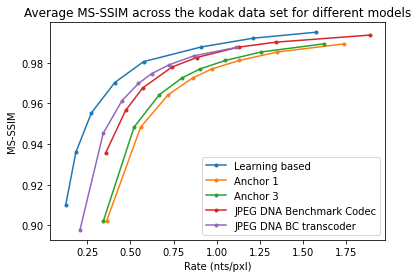

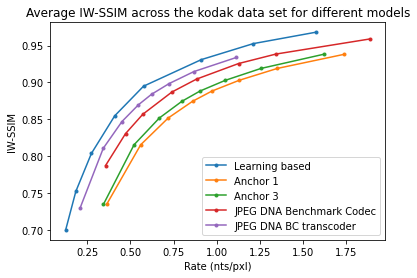

In [ ]:
plot_all_average_metrics('kodak')